# Compare reservoir models
***

**Author:** *Chus Casado Rodríguez*<br>
**Date:** *12-06-2025*<br>

**Introduction:**<br>

This notebooks compares the results of simulating 97 reservoirs from the ResOpsUS. These reservoirs were selected because the include observed data for the three variables inflow, storage and outflow for at least 8 consecutive years.

**Ideas:**<br>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path

import yaml
import pickle

from lisfloodreservoirs import Config, read_attributes, read_timeseries
from lisfloodreservoirs.utils.plots import maps_performance, boxplot_parameters, boxplot_comparison, swarmplot_comparison
from lisfloodreservoirs.utils.metrics import KGEmod, ECDF, PDE
from lisfloodreservoirs.utils.utils import CDF, get_normal_value, return_period
from lisfloodreservoirs.calibration import read_results

In [2]:
plt.rcParams.update({
    "font.family": 'Arial',
    "font.size": 13,       # Default font size for text
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 12,  # X and Y label font size
    "xtick.labelsize": 13, # X tick font size
    "ytick.labelsize": 12, # Y tick font size
    "legend.fontsize": 12  # Legend font size
})

## Configuration

In [3]:
cfg = Config('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/v2.1/results/mhm/mhm_storage.yml')

PATH_RESULTS = cfg.PATH_DEF.parent.parent
print(f'Results will be saved in {PATH_RESULTS}')

models = ['lisflood', 'camaflood', 'mhm', 'starfit']

runs = {
    'default': 'default',
    'SCEUA-Q': 'calibration/univariate/outflow',
    'SCEUA-V': 'calibration/univariate/storage',
    'SCEUA-QV': 'calibration/bivariate'
}

Results will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.1\results


## Data

### Base layers

In [4]:
# load GloFAS' elevation and upstream area map
elevation = rxr.open_rasterio(cfg.PATH_DATA.parent / 'GIS' / 'elv_3min_US.tif', masked=True).squeeze('band')
uparea = rxr.open_rasterio(cfg.PATH_DATA.parent / 'GIS' / 'upArea_3min_US.tif', masked=True).squeeze('band')

### Reservoirs

In [5]:
# load reservoirs
reservoirs = gpd.read_file(cfg.PATH_DATA.parent / 'ancillary' / 'lfcoords' / 'reservoirs_677_3sec.shp').set_index('ID')
reservoirs.index.name = 'GRAND_ID'

print(f'{len(reservoirs)} reservoirs in the original ResOpsUS dataset')

677 reservoirs in the original ResOpsUS dataset


### Attributes

In [6]:
# list of reservoirs to be trained
reservoir_list = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

# import all tables of attributes
attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoir_list)

# invert the one-hot encoder of main reservoir use
col_use = attributes.columns[attributes.columns.str.contains('MAIN_')]
col_use = [col for col in col_use if 'BASIN' not in col]
main_use = attributes[col_use].idxmax(axis=1)
attributes['MAIN_USE'] = main_use.replace({col: col.split('_')[-1] for col in col_use})
attributes.drop(col_use, axis=1, inplace=True)

print(f'{len(attributes)} reservoirs in the attributes table')

164 reservoirs in the attributes table


Create shapefile of the reservoirs selected for the model comparison.

```Python
import geopandas as gpd

# convert to GeoPandas
attributes = gpd.GeoDataFrame(
    attributes,
    geometry=gpd.points_from_xy(attributes.LON_LISFLOOD, attributes.LAT_LISFLOOD),
    crs='epsg:4326'
)

# export shapefile
attributes.to_file(cfg.PATH_DATA / 'selection' / 'reservoirs.shp')
```

### Time series

In [7]:
# training periods
with open(cfg.PERIODS_FILE, 'rb') as file:
    periods = pickle.load(file)
# periods = {str(ID): {f'{x}_dates': [date] for x, date in dct.items()} for ID, dct in periods.items()}

# read time series
inputs = [var for var in [cfg.INFLOW, cfg.PRECIPITATION, cfg.EVAPORATION, cfg.DEMAND] if var]
outputs = ['storage', 'outflow']
timeseries = read_timeseries(
    path=cfg.PATH_DATA / 'time_series' / 'csv',
    reservoirs=attributes.index,
    periods=periods,
    variables=inputs + outputs
)
print(f'{len(timeseries)} reservoirs in the time series')

# compute 100-year return period of the inflow
Q100 = [return_period(ts.inflow, T=100) for grand_id, ts in timeseries.items()]
Q100 = xr.DataArray(data=Q100, coords=[list(timeseries)], dims=['ID'])

  0%|          | 0/164 [00:00<?, ?it/s]

164 reservoirs in the time series


## Load results

In [49]:
parameters = {}
performance = []
for model in tqdm(models, desc='reservoir model'):

    pars_model = []
    perf_model = []
    for run, subpath in runs.items():

        path = PATH_RESULTS / model / subpath

        # load parameters
        try:
            pars_run = []
            for file in path.glob('*_parameters.yml'):
                grand_id = int(file.stem.split('_')[0])
                if grand_id not in attributes.index:
                    continue
                with open(file, 'r') as f:
                     dct = yaml.load(f, Loader=yaml.FullLoader)
                ds = xr.Dataset({key: xr.DataArray(value) for key, value in dct.items()})
                ds = ds.assign_coords(ID=[grand_id], run=[run])
                pars_run.append(ds)
            pars_model.append(xr.concat(pars_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading parameters from model {model} and run {run}:\n{e}')          

        # load performance
        try:
            perf_run = []
            for file in (path).glob('*_performance.csv'):
                grand_id = int(file.stem.split('_')[0])
                if grand_id not in attributes.index:
                    continue
                ds = xr.Dataset.from_dataframe(pd.read_csv(file, index_col='metric'))
                ds = ds.assign_coords(model=[model], run=[run], ID=[grand_id])
                perf_run.append(ds)
            perf_model.append(xr.concat(perf_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading performance from model {model} and run {run}:\n{e}')  
    
    try:
        parameters[model] = xr.concat(pars_model, dim='run')
    except:
        pass
    try:
        performance.append(xr.concat(perf_model, dim='run'))
    except:
        pass

performance = xr.concat(performance, dim='model')

# rename model 'hanazaki' as 'camaflood'
performance = performance.assign_coords(
    model=[m if 'hanazaki' not in m else 'camaflood' for m in performance.model.values]
)
remap_models ={
    'lisflood': 'LISFLOOD', 
    'camaflood': 'CaMa-Flood', 
    'mhm': 'mHM', 
    'starfit': 'Starfit'
}
performance = performance.assign_coords(model=[remap_models[model] for model in performance.model.values])

reservoir model:   0%|          | 0/4 [00:00<?, ?it/s]

Error while reading parameters from model starfit and run default:
must supply at least one object to concatenate
Error while reading performance from model starfit and run default:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-Q:
must supply at least one object to concatenate
Error while reading performance from model starfit and run SCEUA-Q:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-V:
must supply at least one object to concatenate
Error while reading performance from model starfit and run SCEUA-V:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-QV:
must supply at least one object to concatenate


## Analysis

### Reservoirs

Map of the reservoirs included in the study. This will be Figure 1 in the section Data of the paper.

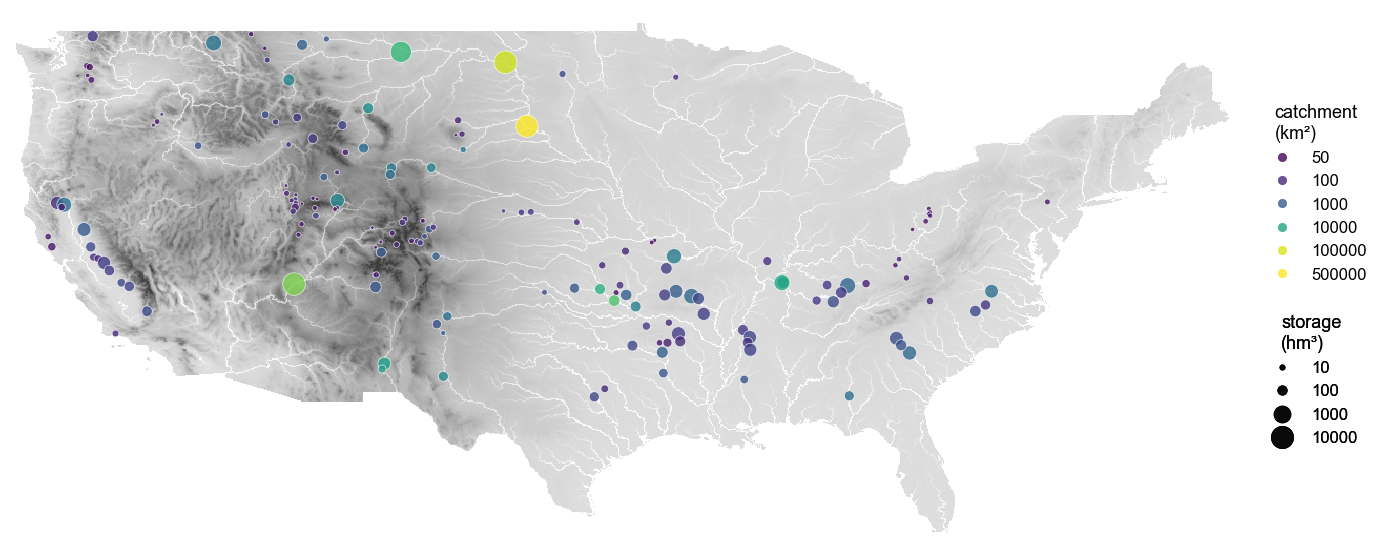

In [9]:
# set up plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(16, 8), 
    subplot_kw={'projection': proj}
)

# base layers
elevation.plot(
    ax=ax, 
    cmap='Greys', 
    alpha=1, 
    vmin=-100,
    vmax=4000,
    add_colorbar=False,
    zorder=1
)
uparea.plot(
    ax=ax, 
    cmap='Greys_r', 
    alpha=.3, 
    vmin=-22 * 1e9,
    vmax=22* 1e9,
    add_colorbar=False,
    zorder=3
)

# selected reservoirs
reservoirs_selected = reservoirs.loc[reservoirs.index.intersection(attributes.index)]
scatter = ax.scatter(
    reservoirs_selected.geometry.x,
    reservoirs_selected.geometry.y,
    c=attributes.loc[reservoirs_selected.index, 'CATCH_SKM']**.25,
    s=attributes.loc[reservoirs_selected.index, 'CAP_MCM']**.5 * 1.5,
    alpha=.8,
    edgecolor='w',
    lw=.5,
    zorder=10
)

# color legend
labels1 = [50, 100, 1000, 10000, 100000, 500000, 600000]
handles1, foo = scatter.legend_elements(
    prop='colors', 
    num=list((np.array(labels1))**.25),
    alpha=.8
)
legend1 = ax.legend(
    handles1,
    labels1,
    title='catchment\n(km²)', 
    loc='upper left',
    bbox_to_anchor=[1, .5, .1, .35], 
    frameon=False
)
fig.add_artist(legend1)

# size legend
labels2 = [10, 100, 1000, 10000, 30000]
handles2, foo = scatter.legend_elements(
    prop='sizes', 
    num=list(np.sqrt(labels2) * 1.5),
    alpha=.8
)
legend2 = ax.legend(
    handles2,
    labels2,
    title='storage\n(hm³)', 
    loc='upper left',
    bbox_to_anchor=[1, .1, .1, .35], 
    frameon=False
)
fig.add_artist(legend2)
        
ax.set_extent([-125, -66, 25, 50], crs=proj)
ax.set_title(None)
ax.set_aspect('equal')
ax.axis('off');

# plt.savefig(PATH_RESULTS / 'figure1.pdf', dpi=300, bbox_inches='tight');

### Performance

#### Compare simulations

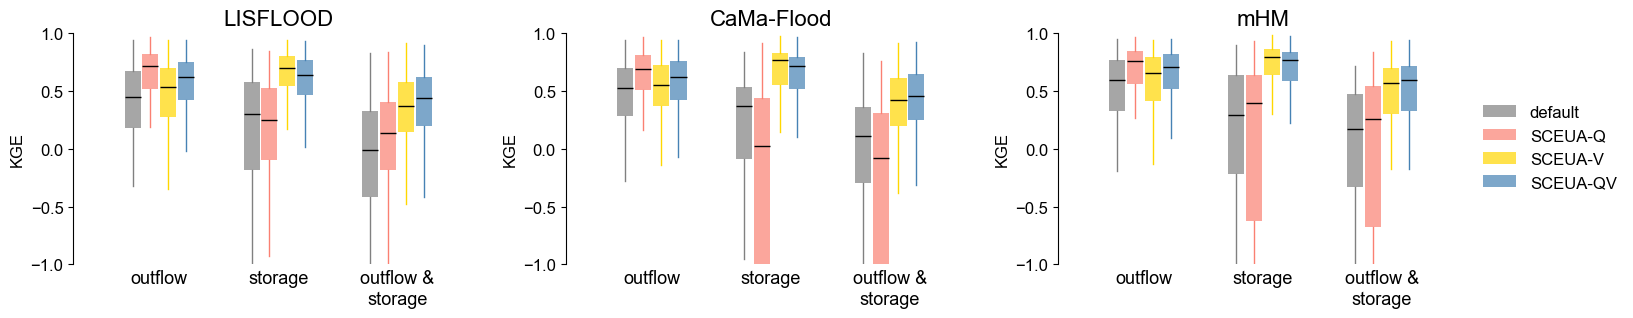

In [52]:
# compare runs
boxplot_comparison(
    performance.sel(model=['LISFLOOD', 'CaMa-Flood', 'mHM'], run=['default', 'SCEUA-Q', 'SCEUA-V', 'SCEUA-QV']),
    ax_dim='model',
    col_dim='run',
    # save=PATH_RESULTS / f'boxplots_compare_variables.pdf'
)

C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 73.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\DEV\Anaconda3\envs\reservoirs\Lib\site-packages\seaborn\categorical.py

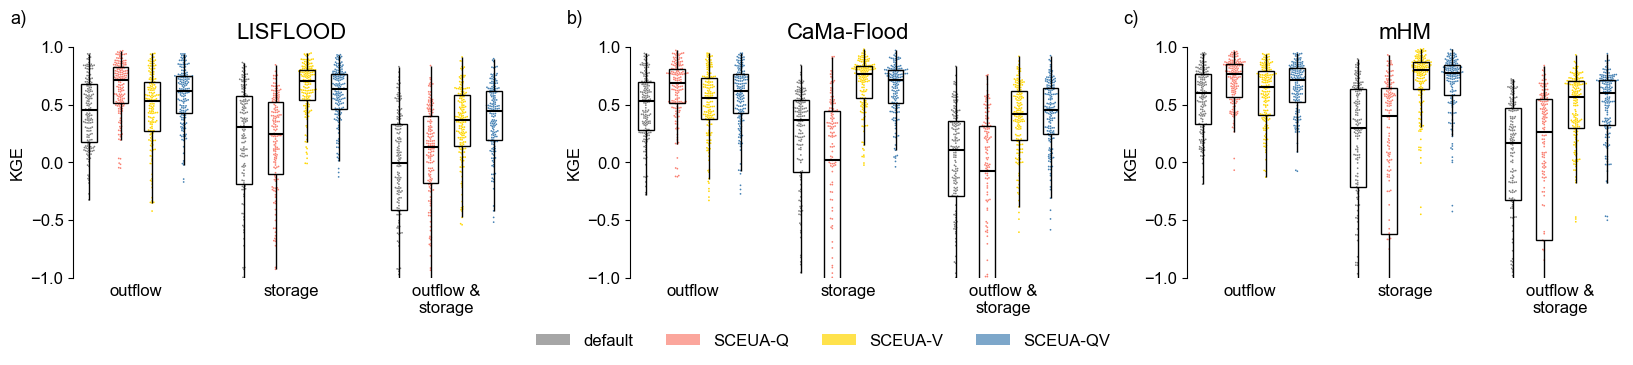

In [51]:
# compare runs
swarmplot_comparison(
    performance.sel(model=['LISFLOOD', 'CaMa-Flood', 'mHM'], run=['default', 'SCEUA-Q', 'SCEUA-V', 'SCEUA-QV']),
    ax_dim='model',
    col_dim='run',
    kind='swarm',
    size=1.25,
    save=PATH_RESULTS / f'swarmplots_compare_variables.pdf'
)

#### Compare models

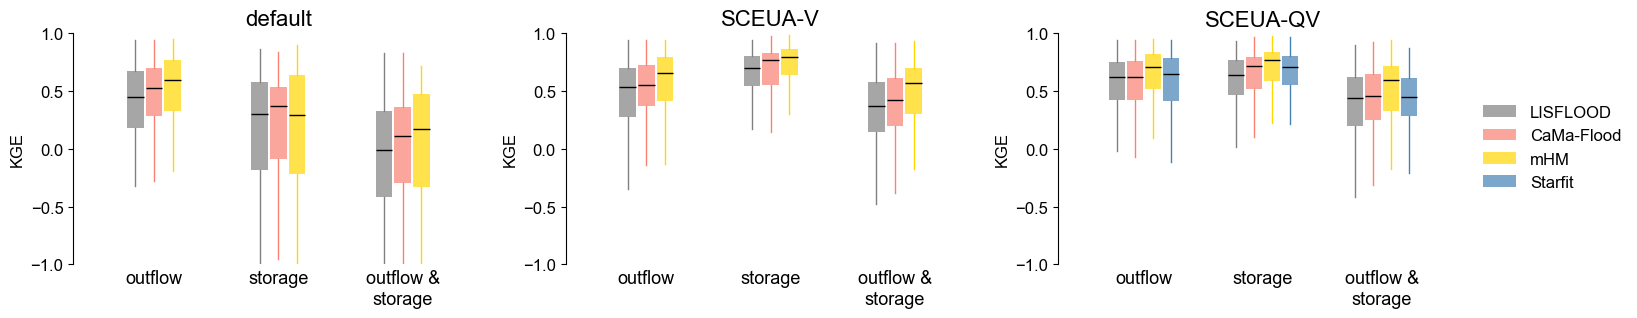

In [54]:
# compare models
boxplot_comparison(
    performance.sel(model=['LISFLOOD', 'CaMa-Flood', 'mHM', 'Starfit'], run=['default', 'SCEUA-V', 'SCEUA-QV']),
    ax_dim='run',
    col_dim='model',
    # save=PATH_RESULTS / f'boxplots_compare_models.pdf'
)

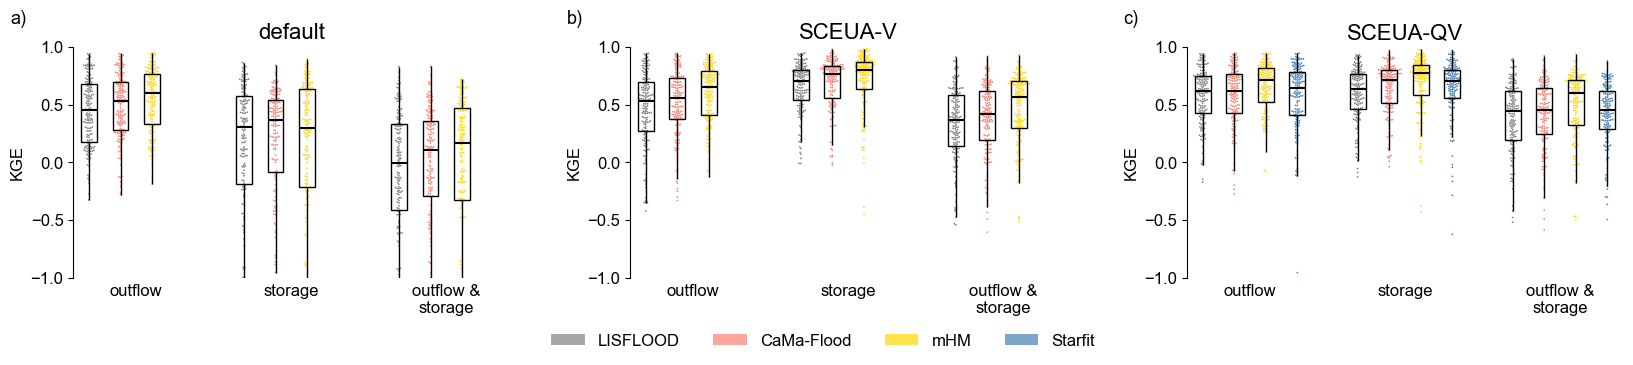

In [55]:
# compare models
swarmplot_comparison(
    performance.sel(model=['LISFLOOD', 'CaMa-Flood', 'mHM', 'Starfit'], run=['default', 'SCEUA-V', 'SCEUA-QV']),
    ax_dim='run',
    col_dim='model',
    kind='swarm',
    size=1.25,
    save=PATH_RESULTS / f'swarmplots_compare_models.pdf'
)

***

***

Figure explaining the mHM model.

```Python
from mpl_toolkits.mplot3d import Axes3D

demand_vals = np.linspace(0, 20, 50)
inflow_vals = np.linspace(0, 20, 50)
D, I = np.meshgrid(demand_vals, inflow_vals)
omega = 0.1
dor = 1.176
beta = 1
gamma = 0.85
lamb = 1

rho = min(1, (1 / dor)**beta)
print(f'rho = {rho:.3f}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for V in [0.01, .25, 0.5, .75, 0.99]:
    kappa = (V / gamma)**lamb
    Q = rho * kappa * D + (1 - rho) * I
    color = plt.cm.magma(V)
    ax.plot_surface(D, I, Q, color=color)#cmap=cmap, alpha=.75)
# ax.set_xlabel('demand')
# ax.set_ylabel('inflow')
# ax.set_zlabel('outflow')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title('Outflow as a Function of Demand, Inflow & Storage')
plt.show()
```

***

***

### Parameters

#### Linear

In [ ]:
model = 'linear'
parameter_range = {'T': [7, 2190]}

pars_model = parameters[model][list(parameter_range)]

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# pairplot comparing runs for each parameter
for parname, da in pars_model.items():
    data = da.to_pandas().transpose()
    pairplot= sns.pairplot(data=data,
                           # diag_kind='hist',
                           # hue='MAIN_USE', 
                           corner=True);
    pmin, pmax = parameter_range[parname]
    pmin -= 2e-2
    pmax += 2e-2
    for ax in pairplot.axes.flatten():
        if ax is None:
            continue
        ax.set(xlim=(pmin, pmax),
               ylim=(pmin, pmax))
    pairplot.fig.suptitle(parname, y=.95);
    plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Lisflood

In [ ]:
model = 'lisflood'

parameter_range = {
    'alpha': [0.20, 0.99],
    'beta': [0.001, 0.999],
    'gamma': [0.001, 0.999],
    'delta': [0.1, 0.5],
    'epsilon': [0.001, 0.999],
    'k': [1.0, 5.0]
}

pars_model = parameters[model]
pars_model = xr.Dataset({
    'alpha': pars_model['Vf'] / pars_model['Vtot'],
    'beta': (pars_model['Vn'] - pars_model['Vmin']) / (pars_model['Vf'] - pars_model['Vmin']),
    'gamma': (pars_model['Vn_adj'] - pars_model['Vn']) / (pars_model['Vf'] - pars_model['Vn']),
    'delta': pars_model['Qf'] / Q100,
    'epsilon': pars_model['Qn'] / pars_model['Qf'],
    'k': pars_model['k']
})

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        palette='Spectral',
        diag_kind='hist',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.8, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pars_model.median('ID').to_pandas()

#### Hanazaki

In [ ]:
ds = parameters['hanazaki']

ds

In [ ]:
ds.where((ds['Ve'] > ds['Vtot']).any('run'), drop=True)

In [ ]:
ds[['Qmin', 'Qn']].sel(ID=[7313]).to_dataframe()

In [ ]:
from lisfloodreservoirs.models import Lisflood

In [ ]:
res = Lisflood(Qf=347,
               Qmin=0.0,
               Qn=6.4,
               Vf=105879765,
               Vmin=11089100,
               Vn=83263414,
               Vn_adj=97339496,
               Vtot=110891000,
               k=1.158)

In [ ]:
res.plot_routine()

In [ ]:
ts = timeseries[42]
sim = res.simulate(ts.inflow, ts.storage.iloc[0], routine=1, limit_Q=True)

In [ ]:
res.get_params()

In [ ]:
res.scatter(sim, ts, norm=False,
            Vlims=[11089100, 83263414, 97339496, 105879765],
            Qlims=[0.0, 6.4, 6.4, 347])

In [ ]:
ts.inflow.mean() * 3600 * 24 * 1e-6

In [ ]:
(res.Vf - res.Vn_adj) * 1e-6

In [ ]:
ds[['Vtot', 'Vf']].sel(ID=1777).to_pandas()

In [ ]:
pars_model['alpha'].where(pars_model['alpha'] < 0.2, drop=True).to_pandas()

In [ ]:
pars_model['epsilon'].to_pandas().min(axis=1)

In [ ]:
timeseries[1777].storage.plot()

In [ ]:
attributes.loc[1777, 'CAP_MCM']

In [ ]:
model = 'hanazaki'

parameter_range = {
    'alpha': [0.2, 0.99],
    'beta': [0.001, 0.999],    
    'gamma': [0.001, 0.999],
    'delta': [0.1, 0.5],
    'epsilon': [0.001, 0.999]
}

pars_model = parameters[model]
pars_model = xr.Dataset({
    'alpha': pars_model['Vf'] / pars_model['Vtot'],
    'beta': (pars_model['Vtot'] - pars_model['Ve']) / (pars_model['Vtot'] - pars_model['Vf']),
    'gamma': pars_model['Vmin'] / pars_model['Vf'],
    'delta': pars_model['Qf'] / Q100,
    'epsilon': pars_model['Qn'] / pars_model['Qf']
})

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

#### mHM

In [ ]:
model = 'mhm'

parameter_range = {
    'w': [0.0, 1.0],
    'alpha': [0.0, 5.0],
    'beta': [0.5, 3.0],
    'gamma': [0.0, 1.0],
    'lambda': [0.25, 3.0]
}

pars_model = parameters[model][list(parameter_range)]

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pars_model.median('ID').to_pandas()

## Correct parameter files

```Python
from lisfloodreservoirs.calibration import read_results
from lisfloodreservoirs.utils.timeseries import create_demand
from lisfloodreservoirs.models import get_model
import copy

for model in ['mhm']:
    for run in ['SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']:
        # path results
        path = PATH_RESULTS / model / runs[run]

        for file in path.glob('*samples.csv'):
                    
            # reservoir ID and time series
            grand_id = int(file.stem.split('_')[0])
            ts = timeseries[grand_id]

            # storage attributes (m3)
            Vtot = ts.storage.max()
            Vmin = max(0, ts.storage.min())
            # flow attributes (m3/s)
            Qmin = max(0, ts.outflow.min())
            # model-independent reservoir attributes
            reservoir_attrs = {
                'Vmin': Vmin,
                'Vtot': Vtot,
                'Qmin': Qmin,
                }
            if model == 'hanazaki':
                # catchment area (m2)
                A = int(attributes.loc[grand_id, 'CATCH_SKM'] * 1e6)
                reservoir_attrs.update({'A': A})
                del reservoir_attrs['Qmin']
            elif model == 'mhm':
                # create a demand time series
                bias = ts.outflow.mean() / ts.inflow.mean()
                demand = create_demand(ts.outflow,
                                       water_stress=min(1, bias),
                                       window=28)

            # read calibration results
            iterations, attributes = read_results(file)

            # udpate reservoir attributes
            calibrated_attrs = copy.deepcopy(reservoir_attrs)
            if model == 'hanazaki':
                Vf = float(ts.storage.quantile(attributes['alpha']))
                Ve = Vtot - attributes['beta'] * (Vtot - Vf)
                Vmin = attributes['gamma'] * Vf
                Qn = attributes['delta'] * ts.inflow.mean()
                Qf = attributes['epsilon'] * return_period(ts.inflow, T=100)
                calibrated_attrs.update({
                    'Vf': Vf,
                    'Ve': Ve,
                    'Vmin': Vmin,
                    'Qn': Qn,
                    'Qf': Qf,
                    'A': A
                })
            elif model == 'mhm':
                calibrated_attrs.update(attributes)
                calibrated_attrs.update({
                    'avg_inflow': ts.inflow.mean(),
                    'avg_demand': demand.mean()
                })

            # declare reservoir
            res = get_model(model, **calibrated_attrs)
            
            # export calibrated attributes
            with open(path / f'{grand_id}_optimal_attributes.yml', 'w') as f:
                yaml.dump(res.get_params(), f)
```